In [1]:
import numpy as np
import pandas as pd
import json
import os
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time

from scipy.fft import fft
from scipy.signal import detrend, butter, filtfilt
import pywt


from scipy.signal import resample
from collections import Counter


from skimage.transform import resize
from skimage import img_as_float, img_as_ubyte

# Import

In [2]:
import os
import json
import numpy as np

# Load subject labels
with open("model-data/Labels_epochs.json", "r") as f:
    subject_labels = json.load(f)

def load_data(directory):
    """
    Loads and returns augmented EEG data (X) and corresponding labels (y) from the specified directory.
    """
    X, y = [], []
    for file in os.listdir(directory):
        if file.endswith(".npy"):
            # Load the features (EEG data)
            X_data = np.load(os.path.join(directory, file))
            # Load corresponding label (subject ID matches file naming convention)
            subject_id = file.split("_")[0]
            label = subject_labels.get(subject_id, None)
            if label is not None:
                X.append(X_data)
                y.append(label)
    return np.array(X), np.array(y)

# Preprocessing

## Model 3

In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assume fs (sampling frequency) is known. For example, fs = 250 Hz
fs = 250.0  # Replace this with the actual sampling frequency

# Define your preprocessing function
def preprocess_eeg_data(X, fs, lowcut=1.0, highcut=40.0, order=5):
    """
    Applies preprocessing steps to EEG data:
    - Bandpass filtering
    - Channel-wise standardization (z-score normalization)
    
    Args:
        X (np.ndarray): Raw EEG data (n_subjects, n_epochs, n_channels, n_timesteps).
        fs (float): Original sampling frequency.
        lowcut (float): Lower cutoff frequency for bandpass filter (Hz).
        highcut (float): Upper cutoff frequency for bandpass filter (Hz).
        order (int): Order of the Butterworth filter.

    Returns:
        np.ndarray: Preprocessed EEG data (n_subjects, n_epochs, n_channels, n_timesteps).
    """
    n_subjects, n_epochs, n_channels, n_timesteps = X.shape
    processed_data = np.zeros_like(X)

    # 1. Bandpass Filter Design
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if low <= 0 or high >= 1:
        print(f"Warning: Filter frequencies ({lowcut}Hz, {highcut}Hz) are invalid for Nyquist freq {nyq}Hz. Skipping filter.")
        b, a = None, None
    else:
        try:
            b, a = butter(order, [low, high], btype='band')
        except ValueError as e:
            print(f"Warning: Could not design Butterworth filter (order={order}, freqs=[{low}, {high}]). Skipping filter. Error: {e}")
            b, a = None, None

    # 2. Apply Filter and Standardize Channel by Channel
    for i_subj in range(n_subjects):
        for i_epoch in range(n_epochs):
            for i_ch in range(n_channels):
                channel_data = X[i_subj, i_epoch, i_ch, :]

                # Apply bandpass filter if designed
                if b is not None and a is not None:
                    try:
                        filtered_data = filtfilt(b, a, channel_data)
                    except Exception as e:
                        print(f"Warning: Filtering failed for subject {i_subj}, epoch {i_epoch}, channel {i_ch}. Using original data. Error: {e}")
                        filtered_data = channel_data
                else:
                    filtered_data = channel_data  # Use original if no filter

                # Standardize (z-score normalization)
                mean = np.mean(filtered_data)
                std = np.std(filtered_data)
                if std > 1e-9:
                    processed_data[i_subj, i_epoch, i_ch, :] = (filtered_data - mean) / std
                else:
                    processed_data[i_subj, i_epoch, i_ch, :] = filtered_data - mean  # Only center if std is zero

    return processed_data




# Models

## Model 3: Rakhmatulin et al., 2024

In [13]:
# Modify your EEGNet class to fix the device mismatch
class EEGNet(nn.Module):
    def __init__(self, n_channels, n_timesteps, num_classes,
                 F1=8, D=2, F2=16, kernel_length=64, dropout_rate=0.5):
        super(EEGNet, self).__init__()
        self.n_channels = n_channels
        self.n_timesteps = n_timesteps
        self.num_classes = num_classes
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.kernel_length = kernel_length
        self.dropout_rate = dropout_rate
        
        # Block 1: Temporal Convolution + Depthwise Spatial Convolution
        self.conv1 = nn.Conv2d(19, self.F1, (1, self.kernel_length), padding=(0, self.kernel_length // 2), bias=False)
        self.bn1 = nn.BatchNorm2d(self.F1)
        
        # Depthwise Conv: applied to each feature map spatially (across channels)
        self.depthwise_conv = nn.Conv2d(self.F1, self.F1 * self.D, (self.n_channels, 1), groups=self.F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F1 * self.D)
        
        # Pooling (downsampling)
        self.pool1 = nn.AvgPool2d((1, 4))  # Downsample the time dimension
        
        # Block 2: Separable Convolution
        separable_kernel_length = 16
        self.separable_conv = nn.Sequential(
            nn.Conv2d(self.F1 * self.D, self.F1 * self.D, (1, separable_kernel_length),
                      padding=(0, separable_kernel_length // 2), groups=self.F1 * self.D, bias=False),
            nn.Conv2d(self.F1 * self.D, self.F2, (1, 1), bias=False)
        )
        self.bn3 = nn.BatchNorm2d(self.F2)
        self.pool2 = nn.AvgPool2d((1, 8))  # Further downsampling
        
        # Based on your previous output, the flattened size is 41280
        flatten_size = 41280  # This value comes from your shape output
        self.fc_out = nn.Linear(flatten_size, self.num_classes)
        self.dropout = nn.Dropout(self.dropout_rate)
    
    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.depthwise_conv(x)
        x = F.elu(self.bn2(x))
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Block 2
        x = self.separable_conv(x)
        x = F.elu(self.bn3(x))
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Print the shape before flattening (for debugging)
        print("Shape before flattening:", x.shape)
        
        # Flatten the tensor dynamically
        x = x.view(x.size(0), -1)  # This flattens the tensor
        
        # Print the shape after flattening (for debugging)
        print("Shape after flattening:", x.shape)
        
        # Fully connected layer output
        x = self.fc_out(x)
        return x

# Training

In [5]:
# Modify the input data shape before passing to the model in the training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)  # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()  # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)  # Shape: (batch_size, 476, 19, 190)
            labels = labels.to(device)

            # Reshape inputs from (batch_size, 476, 19, 190) to (batch_size, 19, 190, 476)
            inputs = inputs.permute(0, 2, 3, 1)  # This changes the shape to (batch_size, 19, 190, 476)
            # Now inputs are (batch_size, 19, 190, 476), which matches the expected input for the model

            # Forward pass
            outputs = model(inputs)  # Model expects input shape (batch_size, 19, 190)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad():  # Disable gradient calculations during validation
                for val_inputs, val_labels in val_loader:
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)  # Shape: (batch_size, 476, 19, 190)
                    val_labels = val_labels.to(device)

                    # Reshape validation inputs from (batch_size, 476, 19, 190) to (batch_size, 19, 190, 476)
                    val_inputs = val_inputs.permute(0, 2, 3, 1)  # Shape: (batch_size, 19, 190, 476)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()
                    _, val_predicted = torch.max(val_outputs.data, 1)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")


# Running

## Preprocessing

In [6]:
# train_data, train_labels = load_data("model-data/epochs-numpy-corrected/train")
# test_data, test_labels = load_data("model-data/epochs-numpy-corrected/test")

# # Check shapes of the loaded data
# print(f"Training data shape: {train_data.shape}")
# print(f"Test data shape: {test_data.shape}")




## Model 3

In [7]:
# Force CUDA availability check at the start
assert torch.cuda.is_available(), "CUDA is not available. Please run on a machine with a GPU."
device = torch.device("cuda:0")  # Explicitly use cuda:0
print(f"Using device: {device}")


Using device: cuda:0


In [9]:
# Load your raw data
train_data, train_labels = load_data("model-data/epochs-numpy-corrected/train")
test_data, test_labels = load_data("model-data/epochs-numpy-corrected/test")

# Preprocess the EEG data
train_data_processed = preprocess_eeg_data(train_data, fs=fs)
test_data_processed = preprocess_eeg_data(test_data, fs=fs)


# Check shapes of the processed data
print(f"Processed training data shape: {train_data_processed.shape}")
print(f"Processed test data shape: {test_data_processed.shape}")

Processed training data shape: (240, 476, 19, 190)
Processed test data shape: (104, 476, 19, 190)


In [10]:
# Convert processed data to PyTorch tensors - keep on CPU
train_data_tensor = torch.tensor(train_data_processed, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data_processed, dtype=torch.float32)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Convert train labels and test labels to PyTorch tensors - keep on CPU
train_labels_tensor = torch.tensor(train_labels_encoded, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels_encoded, dtype=torch.long)

In [11]:
# Create DataLoader for training and testing with GPU optimization
batch_size = 32

train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    pin_memory=True,  # Speeds up GPU transfer
    num_workers=4     # Adjust based on HPC capabilities
)

test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True,
    num_workers=4
)

In [15]:


# Create model and ensure it's on CUDA
model3 = EEGNet(n_channels=19, n_timesteps=190, num_classes=len(set(train_labels)))
model3 = model3.to(device)  # Ensure all parameters are on CUDA

# Verify model is on CUDA
print(f"Model is on device: {next(model3.parameters()).device}")

# Loss function
criterion3 = nn.CrossEntropyLoss()

# Optimizer
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Training
num_epochs = 25  # Start with 1 epoch for testing
train_model(model3, train_loader, test_loader, criterion3, optimizer3, num_epochs, device)

Model is on device: cuda:0

--- Training EEGNet ---
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([16, 16, 172, 15])
Shape after flattening: torch.Size([16, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flatteni

# Evaluation

In [16]:
def evaluate_model(model, data_loader, device):
    """
    Evaluates the model's accuracy on the provided data loader.

    Args:
        model (nn.Module): The trained PyTorch model to evaluate.
        data_loader (DataLoader): DataLoader for the dataset to evaluate on (e.g., test_loader or val_loader).
        device (torch.device): The device to run evaluation on (CPU or CUDA).

    Returns:
        float: The accuracy of the model on the dataset (in percentage).
               Returns 0.0 if the data_loader is empty or None.
    """
    if data_loader is None or len(data_loader) == 0:
        print("Warning: Evaluation data loader is empty or None. Returning 0.0 accuracy.")
        return 0.0

    model.to(device)  # Ensure model is on the correct device
    model.eval()      # Set the model to evaluation mode (disables dropout, uses running means/vars for BatchNorm)

    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculations - crucial for evaluation efficiency and correctness
        for inputs, labels in data_loader:
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Check if reshaping is necessary (depending on your model's expected input format)
            if inputs.ndimension() == 4:  # If input is in the format (batch_size, channels, time_steps, features)
                # Reshape or permute as necessary, for example, (batch_size, 19, 190, 476) -> (batch_size, 19, 476, 190)
                inputs = inputs.permute(0, 2, 3, 1)  # Adjust this based on your model's expected input format

            # Forward pass
            outputs = model(inputs)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability/logit

            # Update total samples and correct predictions count
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calculate final accuracy
    accuracy = 100 * correct_predictions / total_samples
    print(f"Evaluation Accuracy: {accuracy:.2f}%")
    return accuracy


In [17]:
evaluate_model(model3, test_loader, device)

Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([8, 16, 172, 15])
Shape after flattening: torch.Size([8, 41280])
Evaluation Accuracy: 41.35%


41.34615384615385

In [18]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_compare_models(models, model_names, data_loader, device, num_classes):
    """
    Evaluate multiple trained models on the same dataset and plot ROC curves.
    
    Args:
        models (list): List of trained PyTorch models.
        model_names (list): List of model names for labeling.
        data_loader (DataLoader): DataLoader for validation or test set.
        device (torch.device): Device for model execution.
        num_classes (int): Total number of output classes.
    
    Returns:
        reports (dict): A dictionary of classification report DataFrames per model.
    """
    reports = {}
    plt.figure(figsize=(8, 6))
    
    for model, name in zip(models, model_names):
        if data_loader is None:
            print(f"Skipping {name}: data_loader is None.")
            continue
        
        model.eval()
        y_true, y_pred, y_probs = [], [], []
        
        with torch.no_grad():
            for X_batch, y_batch in data_loader:
                X_batch = X_batch.to(device)
                
                # Reshape inputs to match model expectations
                # Assuming the model expects shape (batch_size, 19, 190, 476)
                X_batch = X_batch.permute(0, 2, 3, 1)
                
                outputs = model(X_batch)
                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                y_probs.extend(probs)
                y_true.extend(y_batch.numpy())
                
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())
        
        # Print Accuracy
        acc = accuracy_score(y_true, y_pred) * 100  # Convert to percentage
        print(f"\n=== {name} ===")
        print(f"Accuracy: {acc:.2f}%")
        
        # Print classification report
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
        report_df = pd.DataFrame(report).transpose()
        display(report_df[["precision", "recall", "f1-score", "support"]])
        reports[name] = report_df
        
        # Compute ROC Curve (Micro-average for multiclass)
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
        y_probs = np.array(y_probs)
        
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    
    # ROC Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title("Micro-Averaged ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return reports

Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([32, 16, 172, 15])
Shape after flattening: torch.Size([32, 41280])
Shape before flattening: torch.Size([8, 16, 172, 15])
Shape after flattening: torch.Size([8, 41280])

=== EEGNet ===
Accuracy: 41.35%


,precision,recall,f1-score,support
0,0.450000,0.800000,0.576000,45.000000
1,0.291667,0.212121,0.245614,33.000000
2,0.000000,0.000000,0.000000,26.000000
accuracy,0.413462,0.413462,0.413462,0.413462
macro avg,0.247222,0.337374,0.273871,104.000000
weighted avg,0.287260,0.413462,0.327166,104.000000


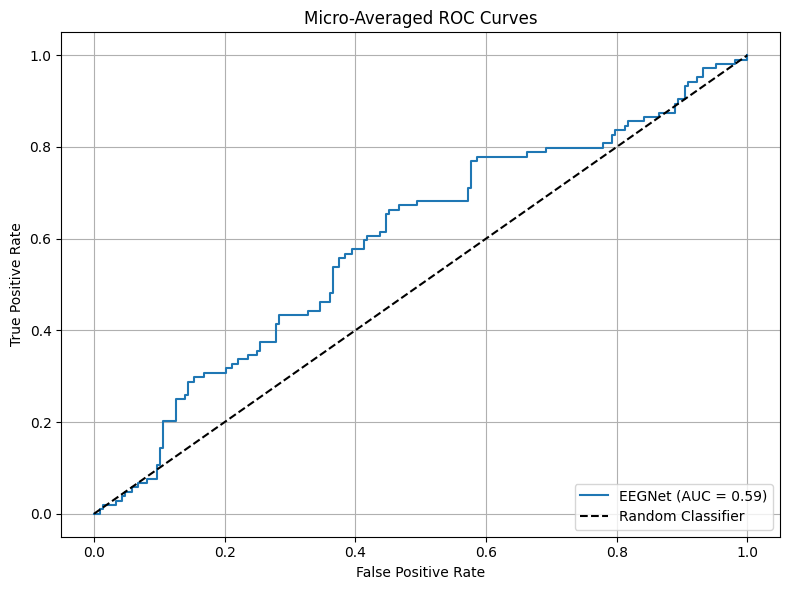

In [19]:
# Set up model list and names
model_list = [model3]  # Assuming model3 is your trained EEGNet model
model_names = ["EEGNet"]

# Get the number of classes from your labels
num_classes_actual = len(set(train_labels))

# Use test_loader since you have both train and test loaders
data_loader_to_use = test_loader  

if data_loader_to_use is None:
    raise ValueError("No data available for evaluation.")

# Call the evaluation function
all_reports = evaluate_and_compare_models(
    models=model_list,
    model_names=model_names,
    data_loader=data_loader_to_use,
    device=device,
    num_classes=num_classes_actual
)